## Fenabrave data extraction, cleaning and transform in a pandas DF

In [1]:
import os
import requests
import tabula
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#Creating variables and URL
previous_month = (datetime.now().month - 1) % 12
formatted_month = f'{previous_month:02d}'

pdfpath = r'C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/'
filename = fr'2024_{formatted_month}_02.pdf'
base_url = 'https://www.fenabrave.org.br/portal/files/'
filepath = base_url + filename

#Downloading the most updated file (last month).pdf
try:
    response = requests.get(filepath)
    response.raise_for_status()
    
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded: {filename}')

except requests.exceptions.HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')
except Exception as err:
    print(f'An error occurred: {err}')

#PDF downloaded here: https://www.fenabrave.org.br/portalv2/
filepath = pdfpath + filename

#To use in date columns
file_date = os.path.splitext(os.path.basename(filepath))[0]
file_date = file_date.replace('_', '-')  #Date format will be: 'YYYY-MM-DD'

tables = tabula.read_pdf(filepath, pages = [11,12,13,14,15,16])

Downloaded: 2024_07_02.pdf


In [2]:
#Creating the first Dataframe
df = pd.concat(tables, ignore_index=True)

df = pd.DataFrame(df.values)

print(tables)

num_rows, num_columns = df.shape

print(f'Rows: {num_rows}')
print(f'Columns: {num_columns}')

[   Modelos mais emplacados acumulado até Jul/2024 Unnamed: 0 Unnamed: 1
0                                      AUTOMÓVEIS        NaN        NaN
1                             Veículos de Entrada        NaN        NaN
2                                       2024 2024       2024        NaN
3                                          Modelo        NaN      Part.
4                                         Jun Jul  Acumulado        NaN
5                        1o FIAT/MOBI 6.007 6.807     39.041     57,20%
6                     2o RENAULT/KWID 4.520 3.520     29.155     42,72%
7                                   3o VW/GOL 2 3         33      0,05%
8                                 4o FIAT/UNO 0 3         10      0,01%
9                                    5o VW/UP 0 1          4      0,01%
10                             6o GM/CHEVETTE 1 0          3      0,00%
11                            7o FIAT/PALIO 0 0 =          2      0,00%
12                                 8o FORD/KA 1 0          1   

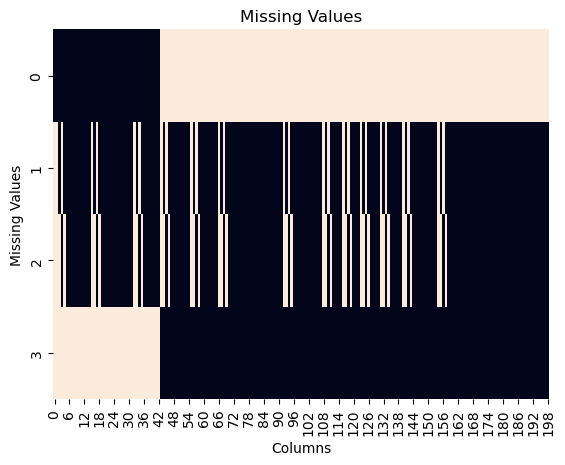

                     0          1      2    3
0           AUTOMÓVEIS        NaN    NaN  NaN
1  Veículos de Entrada        NaN    NaN  NaN
2            2024 2024       2024    NaN  NaN
3               Modelo        NaN  Part.  NaN
4              Jun Jul  Acumulado    NaN  NaN


In [3]:
#Using heatmap to see if dataframe disribution and, missing values

ax = plt.axes()
sns.heatmap(df.isna().transpose(), cbar=False, ax=ax)
plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

print(df.head())

In [4]:
#Fixing the 1st table read problem
switch_col1 = df.pop(df.columns[0])
switch_col2 = df.pop(df.columns[2])

merged_col = switch_col1.astype(str) + switch_col2.astype(str)

df.insert(0, 0, merged_col)

print(df)

                                       0          1      2
0                          AUTOMÓVEISnan        NaN    NaN
1                 Veículos de Entradanan        NaN    NaN
2                           2024 2024nan       2024    NaN
3                              Modelonan        NaN  Part.
4                             Jun Julnan  Acumulado    NaN
..                                   ...        ...    ...
194        nan37o GM/TRAILBLAZER 133 173        987  0,20%
195  nan38o LAND ROVER/DISCOVERY 130 150        983  0,20%
196                nan39o BMW/X3 184 151        878  0,18%
197                nan40o AUDI/Q5 119 89        840  0,17%
198               nanTotal 76.638 90.132    493.228   100%

[199 rows x 3 columns]


In [5]:
#Replace all NaN despite from 1st with an empty string 
df = df.fillna('')

#Clean up unwanted characters nan in the 1st column, after merge
df = df.applymap(lambda x: x.replace('nan', '').strip())

print(df)

                                    0          1      2
0                          AUTOMÓVEIS                  
1                 Veículos de Entrada                  
2                           2024 2024       2024       
3                              Modelo             Part.
4                             Jun Jul  Acumulado       
..                                ...        ...    ...
194        37o GM/TRAILBLAZER 133 173        987  0,20%
195  38o LAND ROVER/DISCOVERY 130 150        983  0,20%
196                39o BMW/X3 184 151        878  0,18%
197                40o AUDI/Q5 119 89        840  0,17%
198               Total 76.638 90.132    493.228   100%

[199 rows x 3 columns]


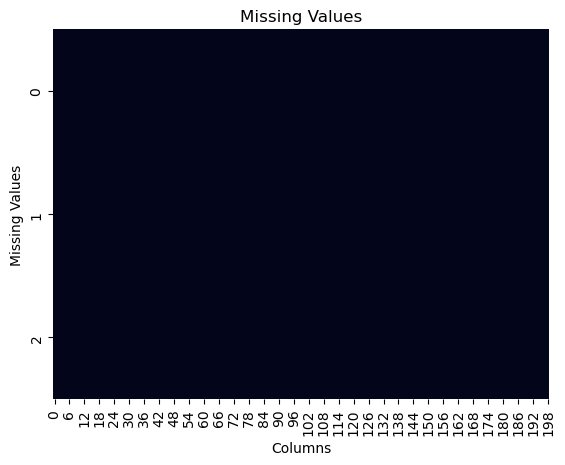

In [6]:
# Checking DF using heatmap agian

ax = plt.axes()
sns.heatmap(df.isna().transpose(), cbar=False, ax=ax)
plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize = 10) 
plt.ylabel('Missing Values', fontsize = 10)
plt.show()

In [7]:
#Creating the 'Category' and 'Date' column with NaN values
df['Category'] = pd.NA
df['Data'] = file_date

#Define regex patterns for categories and Remove rows containing specific keywords
category_patterns = [r'Sedans .*',r'Sw .*',r'Hatch .*','Monocab','Grandcab','Sports',"Suv's"
                     ,'Monocab','Grandcab','Sports','Veículos de Entrada']

drop_patterns = ['Total', 'Sedans', '2024', 'Modelo','Jun', 'Sw', 'Grandcab','Sports', 'Monocab',"Suv's",'Veículos de Entrada'
                ,'Hatch','AUTOMÓVEIS']

category_regex = '|'.join(category_patterns)
drop_regex = '|'.join(drop_patterns)

#Identify category headers and 'Total' rows to be the start of new category
category_indices = df[df[0].str.contains(category_regex, na=False, regex=True)].index
total_indices = df[df[0].str.contains('Total', na=False)].index

#Update the category based on the PDF table title
current_category = None

for row_index in df.index:
    if row_index in category_indices:
        current_category = df.at[row_index, 0]
    elif row_index in total_indices:
        current_category = None
    
    if current_category is not None:
        df.at[row_index, 'Category'] = current_category

#Remove rows with drop conditions
df = df[~df[0].str.contains(drop_regex, na=False)]

print(df)

                                    0       1       2             Category  \
5            1o FIAT/MOBI 6.007 6.807  39.041  57,20%  Veículos de Entrada   
6         2o RENAULT/KWID 4.520 3.520  29.155  42,72%  Veículos de Entrada   
7                       3o VW/GOL 2 3      33   0,05%  Veículos de Entrada   
8                     4o FIAT/UNO 0 3      10   0,01%  Veículos de Entrada   
9                        5o VW/UP 0 1       4   0,01%  Veículos de Entrada   
..                                ...     ...     ...                  ...   
193       36o PORSCHE/CAYENNE 324 175   1.014   0,21%                Suv's   
194        37o GM/TRAILBLAZER 133 173     987   0,20%                Suv's   
195  38o LAND ROVER/DISCOVERY 130 150     983   0,20%                Suv's   
196                39o BMW/X3 184 151     878   0,18%                Suv's   
197                40o AUDI/Q5 119 89     840   0,17%                Suv's   

           Data  
5    2024-07-02  
6    2024-07-02  
7    2024

In [8]:
#Keywords list to transform and fix car name
keywords = ['SEDAN', 'PLUS', 'PALLAS', 'WEEKEND', 'FOX', 'AVANT', 'CROSS', 'CHERY','AIRCROSS','ROVER','H6','SW4'
           ,'HB', 'MINI', 'HATCH', 'TYPE-R', 'GR']

pattern = r'\b(\S+)\s(' + '|'.join(keywords) + r')\b'

patterns_to_replace = [
    'MODEL 3',
    'CLASSE C',
    'ARRIZO 6',
    'TIGGO 5X',
    'TIGGO 7',
    'TIGGO 8',
    'ORA 03',
    'CLASSE A'
]

#More cleaning and transformation
for i in patterns_to_replace:
    df.iloc[:, 0] = df.iloc[:, 0].str.replace(i, i.replace(' ', '_'), regex=False)

df.iloc[:,0] = df.iloc[:,0].str.replace(pattern, r'\1_\2', regex=True)

df.iloc[:,0] = df.iloc[:,0].str.replace('/', ' ', regex=False)

df.iloc[:,0] = df.iloc[:,0].str.replace(' =', '', regex=True)

df = df.applymap(lambda x: x.replace('.', '') if isinstance(x, str) else x)


print(df)

                                    0      1       2             Category  \
5              1o FIAT MOBI 6007 6807  39041  57,20%  Veículos de Entrada   
6           2o RENAULT KWID 4520 3520  29155  42,72%  Veículos de Entrada   
7                       3o VW GOL 2 3     33   0,05%  Veículos de Entrada   
8                     4o FIAT UNO 0 3     10   0,01%  Veículos de Entrada   
9                        5o VW UP 0 1      4   0,01%  Veículos de Entrada   
..                                ...    ...     ...                  ...   
193       36o PORSCHE CAYENNE 324 175   1014   0,21%                Suv's   
194        37o GM TRAILBLAZER 133 173    987   0,20%                Suv's   
195  38o LAND_ROVER DISCOVERY 130 150    983   0,20%                Suv's   
196                39o BMW X3 184 151    878   0,18%                Suv's   
197                40o AUDI Q5 119 89    840   0,17%                Suv's   

           Data  
5    2024-07-02  
6    2024-07-02  
7    2024-07-02  
8  

In [9]:
#df New header
new_header = ['Modelo', 'Acumulado Anual', 'Market Share', 'Categoria', 'Data']

df = pd.concat([pd.DataFrame([new_header], columns=df.columns), df], ignore_index=True)

df.columns = df.iloc[0]
df = df[1:]

print(df)

0                              Modelo Acumulado Anual Market Share  \
1              1o FIAT MOBI 6007 6807           39041       57,20%   
2           2o RENAULT KWID 4520 3520           29155       42,72%   
3                       3o VW GOL 2 3              33        0,05%   
4                     4o FIAT UNO 0 3              10        0,01%   
5                        5o VW UP 0 1               4        0,01%   
..                                ...             ...          ...   
130       36o PORSCHE CAYENNE 324 175            1014        0,21%   
131        37o GM TRAILBLAZER 133 173             987        0,20%   
132  38o LAND_ROVER DISCOVERY 130 150             983        0,20%   
133                39o BMW X3 184 151             878        0,18%   
134                40o AUDI Q5 119 89             840        0,17%   

0              Categoria        Data  
1    Veículos de Entrada  2024-07-02  
2    Veículos de Entrada  2024-07-02  
3    Veículos de Entrada  2024-07-02  
4  

In [10]:
#Split the 'Modelo' column into separate columns (Position, Brand, Car Model, LastMonth, Emplacados)
df[['Pos', 'Marca', 'Modelo', 'LastMonth', 'Emplacados']] = df['Modelo'].str.split(' ', expand=True)

#Reorder columns to have the new columns on the left
df = df[['Pos', 'Marca', 'Modelo', 'LastMonth', 'Emplacados', 'Acumulado Anual', 'Market Share', 'Categoria', 'Data']]


In [11]:
#Drop the pos, lastmonth and market share columns (we will do this fields in the BI part)
df_final = df.drop(df.columns[[0,3,6]], axis=1)

print(df_final)


0         Marca       Modelo Emplacados Acumulado Anual            Categoria  \
1          FIAT         MOBI       6807           39041  Veículos de Entrada   
2       RENAULT         KWID       3520           29155  Veículos de Entrada   
3            VW          GOL          3              33  Veículos de Entrada   
4          FIAT          UNO          3              10  Veículos de Entrada   
5            VW           UP          1               4  Veículos de Entrada   
..          ...          ...        ...             ...                  ...   
130     PORSCHE      CAYENNE        175            1014                Suv's   
131          GM  TRAILBLAZER        173             987                Suv's   
132  LAND_ROVER    DISCOVERY        150             983                Suv's   
133         BMW           X3        151             878                Suv's   
134        AUDI           Q5         89             840                Suv's   

0          Data  
1    2024-07-02  
2  

In [12]:
#See whole DF
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df_final)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

num_rows, num_col = df.shape

print(f'Rows: {num_rows}')
print(f'Columns: {num_columns}')

0         Marca         Modelo Emplacados Acumulado Anual  \
1          FIAT           MOBI       6807           39041   
2       RENAULT           KWID       3520           29155   
3            VW            GOL          3              33   
4          FIAT            UNO          3              10   
5            VW             UP          1               4   
6            GM       CHEVETTE          0               3   
7          FIAT          PALIO          0               2   
8          FORD             KA          0               1   
9            GM          CELTA          0               1   
10           VW           POLO      12543           70405   
11           GM           ONIX       7423           51026   
12      HYUNDAI           HB20       7228           49924   
13         FIAT           ARGO       8663           48284   
14       TOYOTA       YARIS_HB       2819           15132   
15      CITROEN             C3       2111           12242   
16      PEUGEOT         

In [13]:
#.csv Save
csv_filepath =r'C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data.csv'

df_final.to_csv(csv_filepath, index=False, encoding='ISO-8859-1')

print(f'data.csv saved to {csv_filepath}')

data.csv saved to C:/Users/vinig/OneDrive/Documentos/PdfDataExtraction/data.csv


In [14]:
#def update_rds():
from sqlalchemy import create_engine

#RDS connection details
user = ''
password = ''
host = '
port = ''  
database = ''

#Connection string
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'
        
engine = create_engine(connection_string)

try:
    with engine.connect() as connection:
        print("Connected!")
        
        df.to_sql('processed_data', engine, if_exists='append', index=False)

        print(df)
except Exception as e:
    print(f"Error connecting to the db: {e}")
    
query = "SELECT * FROM processed_data LIMIT 10;"
    #pass

SyntaxError: unterminated string literal (detected at line 7) (3138580491.py, line 7)